In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('final_data_endelig_endelig.csv')

C:\Users\vtodd\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.columns

Index(['name', 'age', 'release_date', 'developer', 'price', 'Arabic',
       'Bulgarian', 'Chinese (Simplified)', 'Chinese (Traditional)', 'Czech',
       ...
       'Well-Written', 'Hardware', '8-bit Music', 'BMX', 'Steam Machine',
       'Reboot', 'num_tags', 'id', 'time_delta', 'Shipped'],
      dtype='object', length=466)

In [4]:
for i in df.columns:
    print(i)

name
age
release_date
developer
price
Arabic
Bulgarian
Chinese (Simplified)
Chinese (Traditional)
Czech
Danish
Dutch
English
Finnish
French
German
Greek
Hungarian
Italian
Japanese
Korean
Norwegian
Polish
Portuguese
Portuguese - Brazil
Romanian
Russian
Spanish - Spain
Spanish - Latin America
Swedish
Thai
Turkish
Ukrainian
Vietnamese
num_lang
Indie
Low Confidence Metric
Action
Casual
Adventure
Singleplayer
Simulation
Strategy
RPG
2D
Atmospheric
Puzzle
Free to Play
Early Access
Story Rich
Multiplayer
Pixel Graphics
Fantasy
3D
Colorful
Anime
First-Person
Violent
Cute
Exploration
Arcade
Nudity
Funny
Sexual Content
Sci-fi
Shooter
VR
Platformer
Horror
Great Soundtrack
Retro
Gore
Family Friendly
Relaxing
Difficult
Sports
Open World
Female Protagonist
Action-Adventure
Survival
Co-op
Visual Novel
Third Person
Racing
Comedy
FPS
Massively Multiplayer
Stylized
Realistic
Old School
Top-Down
Sandbox
Physics
Turn-Based
Online Co-Op
PvP
Shoot 'Em Up
Choices Matter
Mystery
Point & Click
Space
Minimalist

In [5]:
y = df['price']

#only taking values, where we don't have a zero count across all observations
X = df.drop(columns = ['name', 'release_date', 'developer','price', 'id']).loc[:, (df != 0).any(axis=0)]

In [6]:
# from sklearn.preprocessing import LabelEncoder

# LE = LabelEncoder()
# X['developer'] = LE.fit_transform(X['developer'])
X.age = X.age.astype('str').str.rstrip('+').astype(int)

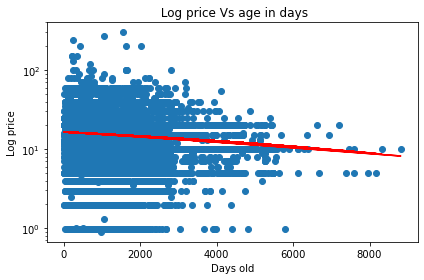

In [7]:
fig = plt.figure()
plt.yscale('log')
plt.title(' Log price Vs age in days')
plt.xlabel('Days old')
plt.ylabel('Log price')
plt.scatter(X['time_delta'], y)
m, b = np.polyfit(X['time_delta'], y, 1)
plt.plot(X['time_delta'], m*X['time_delta'] + b, color = 'red')
fig.tight_layout()

In [8]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.model_selection import train_test_split

In [9]:
X_dev, X_test, y_dev, y_test = train_test_split(X.values, y.values, test_size = 2/10, random_state = 1337)

In [10]:
X_scaled = StandardScaler().fit_transform(X_dev)

In [11]:
X_scaled.shape

(7581, 453)

In [12]:
from sklearn.decomposition import PCA

pcamodel = PCA(n_components = 453)
pcamodel.fit(X_scaled)

PCA(n_components=453)

In [13]:
for i in range(453):
    if sum(pcamodel.explained_variance_ratio_[0:i]) >= 0.90:
        print(i)
        break

333


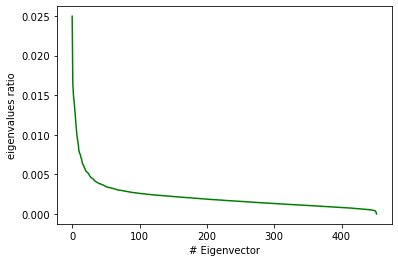

In [14]:
eigenvalues = pcamodel.explained_variance_ratio_
fig1, ax1 = plt.subplots()
ax1.plot(eigenvalues, color = 'green')
#ax1.set_yscale('log')
ax1.set(xlabel = '# Eigenvector', ylabel = 'eigenvalues ratio')
plt.show()

In [15]:
pcamodel.set_params(n_components = 333)
X_pca = pcamodel.fit_transform(X_scaled)

In [16]:
# First we perform parameter tuning on the lambda of the lasso model
# The first search was done in the space np.logspace(-4, 4, 12)
# Here we found that a lambda of 0.0028... was the best, so we narrow the space down in a grid search further below

In [17]:
from sklearn.model_selection import KFold
lambdas =  np.logspace(-4, 4, 12)
kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))
MSE_lambda_lasso = []
for lambda_ in lambdas:
    MSE_cv = []
    for train_idx, val_idx in folds:
        
        pipe_Lasso = make_pipeline(StandardScaler(),\
                                   PCA(n_components = 333),\
                                   #PolynomialFeatures(degree = 2, include_bias = False),\
                                   Lasso(alpha = lambda_, random_state = 1337))
        X_train, y_train = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx]
        pipe_Lasso.fit(X_train, y_train)
        MSE_cv.append(mse(pipe_Lasso.predict(X_val), y_val))
        
    MSE_lambda_lasso.append(np.mean(MSE_cv))

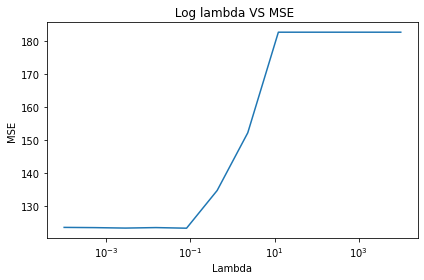

In [18]:
lambdaCV_lasso = pd.Series(MSE_lambda_lasso, index=lambdas)
fig = plt.figure()
plt.xscale('log')
plt.title(' Log lambda VS MSE')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.plot(lambdaCV_lasso)
fig.tight_layout()

In [19]:
lambdaCV_lasso

0.000100        123.571375
0.000534        123.503219
0.002848        123.365230
0.015199        123.513791
0.081113        123.327692
0.432876        134.775665
2.310130        152.277017
12.328467       182.803938
65.793322       182.803938
351.119173      182.803938
1873.817423     182.803938
10000.000000    182.803938
dtype: float64

In [20]:
lambdaCV_lasso.nsmallest(1)

0.081113    123.327692
dtype: float64

In [21]:
np.logspace(-3,-1,12)

array([0.001     , 0.00151991, 0.00231013, 0.00351119, 0.0053367 ,
       0.00811131, 0.01232847, 0.01873817, 0.02848036, 0.04328761,
       0.06579332, 0.1       ])

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

lambdas =  np.logspace(-3, -1, 12)
pipe_ElasticNet = make_pipeline(StandardScaler(),
                                PCA(n_components = 333),
                                #PolynomialFeatures(degree = 2, include_bias = False),
                                ElasticNet(random_state = 1337))

gs_ElasticNet = GridSearchCV(estimator=pipe_ElasticNet,
                             param_grid={'elasticnet__alpha':lambdas,
                                         'elasticnet__l1_ratio': np.linspace(0,1,10)},
                             scoring='neg_mean_squared_error',
                             n_jobs=4,
                             cv=10)

In [23]:
gs_ElasticNet.fit(X_dev, y_dev)
gs_ElasticNet.best_params_

{'elasticnet__alpha': 0.06579332246575682, 'elasticnet__l1_ratio': 0.0}

In [24]:
print(mse(gs_ElasticNet.predict(X_dev), y_dev))
print(mse(gs_ElasticNet.predict(X_test), y_test))

113.79702160845636
122.06083772232361


In [52]:
# We need same columns as in original data

In [46]:
upcoming = pd.read_csv('test_data.csv')
y_upcoming = upcoming['price']

# Same columns as in X - our training data
X_upcoming = upcoming.drop(columns = ['row_num', 'name', 'release_date', 'developer','price', 'id',\
                                     #'Chinese (Simplified)', 'Chinese (Traditional)', 'Low Confidence Metric',\
                                     #'Adult Content', 'Base Building', 'Dystopian', 'eSports', 'Parody'\
                                     ])

In [54]:
#df.loc[:,(df==0).all(axis=0)]
#X_upcoming[X.columns]

In [72]:
final_model = make_pipeline(StandardScaler(),
                                PCA(n_components = 333),
                                ElasticNet(alpha = gs_ElasticNet.best_params_['elasticnet__alpha'],\
                                           l1_ratio = gs_ElasticNet.best_params_['elasticnet__l1_ratio'],\
                                           random_state = 1337))

In [73]:
final_model.fit(X_dev, y_dev)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=333)),
                ('elasticnet',
                 ElasticNet(alpha=0.06579332246575682, l1_ratio=0.0,
                            random_state=1337))])

In [77]:
print(mse(final_model.predict(X_dev), y_dev))
print(mse(final_model.predict(X_test), y_test))

114.00796463914232
122.57170997342072
